In [169]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [170]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [171]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [172]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [173]:
X = train_data.drop('label',axis=1)
y = train_data['label']


In [174]:
classes = y.unique()
num_classes = len(y.unique())

print (classes)
print (num_classes)

[1 0 4 7 3 5 8 9 2 6]
10


In [175]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [176]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size = 3, stride = 1, padding =1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding=1)
        self.fc1 = nn.Linear(64*7*7, num_classes)
#        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = x.view(x.size(0), -1) #Flatten the tensor
        x = self.fc1(x)
   #     x = self.fc2(x)
        return x

In [177]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_train_reshaped = X_train_tensor.view(X_train_tensor.shape[0], 1, 28, 28)
#Create the TensorData and DataLoader
train_dataset = TensorDataset(X_train_reshaped, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)

In [178]:

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_reshaped = X_test_tensor.view(X_test_tensor.shape[0], 1, 28, 28)
#Create the TensorData and DataLoader
test_dataset = TensorDataset(X_test_reshaped, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

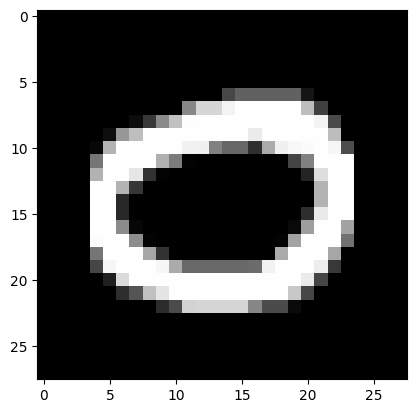

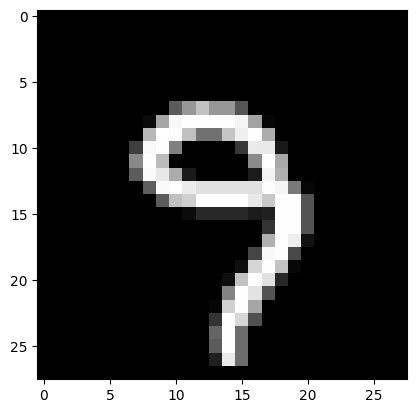

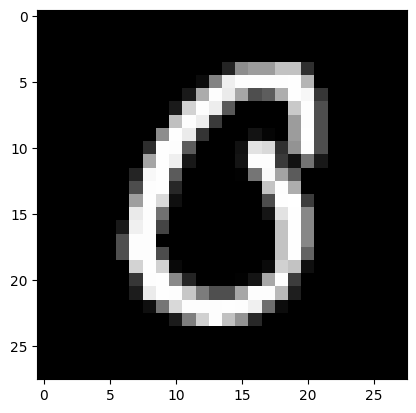

In [179]:
def preview_image (tensor, index):
    '''
    Preview the image of the train or test set
    '''
    img = tensor[index].numpy()
    img = img.reshape(28,28)
    plt.imshow(img, cmap = "gray")
    plt.show()

preview_image(X_train_tensor, 0)
preview_image(X_train_tensor, 25)
preview_image(X_train_tensor, 5)

In [180]:
import torch.optim as optim

model = Net(num_classes = 10)
print (model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(4):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)
Epoch 1, Loss: 0.34941645261560694
Epoch 2, Loss: 0.18431805232950013
Epoch 3, Loss: 0.1596681903264745
Epoch 4, Loss: 0.15045903073719671
Finished Training


In [215]:
#Evaluating Model Performance

from torchmetrics import Recall
from torchmetrics import Precision

metric_recall = Recall(task = "multiclass", num_classes = 10, average = "micro")
metric_precision = Precision(task = "multiclass", num_classes = 10, average = "micro")


model.eval()
preds_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds.tolist())
        labels_list.extend(labels.tolist())
        metric_precision(preds, labels)
        metric_recall(preds, labels)

    
precision = metric_precision.compute()
recall = metric_recall.compute()

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.9530952572822571
Recall: 0.9530952572822571


In [216]:
# Convert predictions list to Pandas Series
prediction_df = pd.DataFrame()
prediction_df['Actual'] = y_test
prediction_df['Predictions'] = preds_list

prediction_df

,Actual,Predictions
0,3,2
1,6,5
2,9,8
3,5,8
4,6,3
...,...,...
12595,5,6
12596,1,9
12597,1,1
12598,6,1


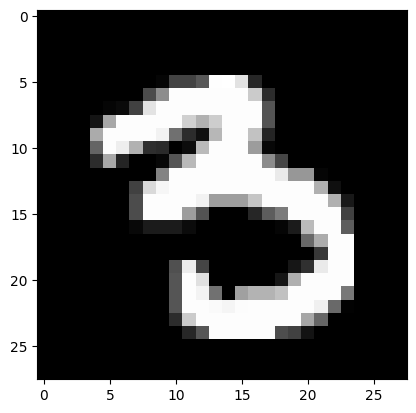

In [197]:
preview_image(X_test_tensor, 0)

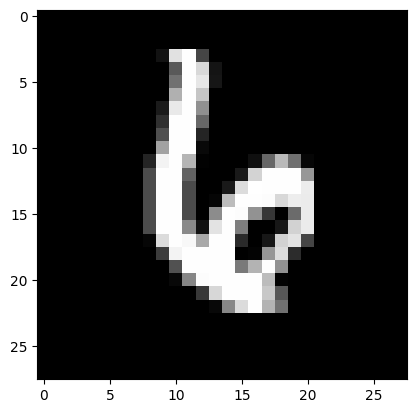

Actual         6
Predictions    5
Name: 4, dtype: int64

In [208]:
preview_image(X_test_tensor, 4)
prediction_df.loc[4]

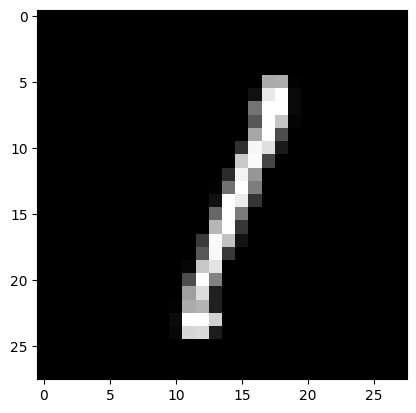

Actual         1
Predictions    1
Name: 12597, dtype: int64

In [214]:
preview_image(X_test_tensor, 12597)

prediction_df.iloc[12597,]